In [58]:
from scipy.optimize import curve_fit
import scipy
from matplotlib import rc

# For interacting with the data
import h5py
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import json
import qnm

rc('text', usetex=True)

# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 30
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 20
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3


In [50]:
## Download QNM code
import os, ssl
## bypass the verification
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)): 
    ssl._create_default_https_context = ssl._create_unverified_context
qnm.download_data()
ksc = qnm.cached.KerrSeqCache(init_schw=True) # Only need init_schw once

Destination path /Users/mokounkova/Library/Python/3.7/lib/python/site-packages/qnm/data.tar.bz2 already exists, use overwrite=True to force an overwrite.


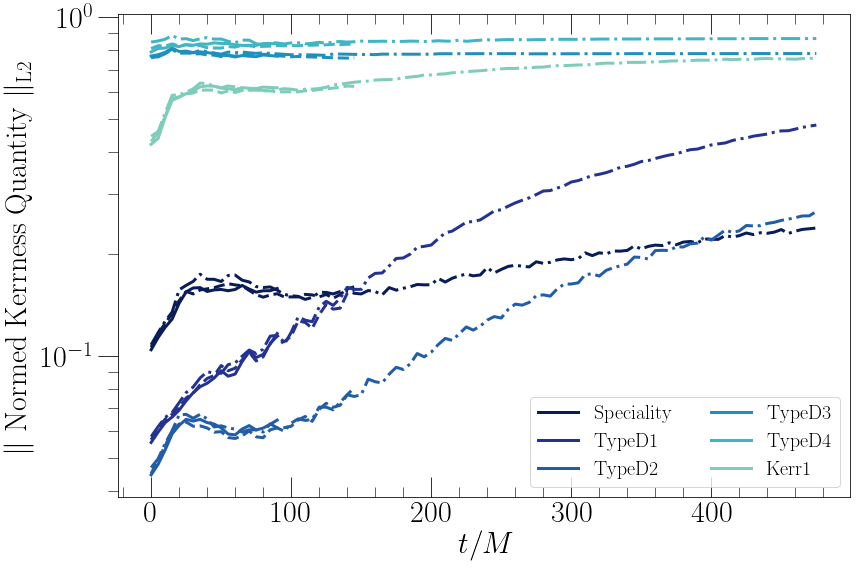

In [47]:
def PlotValues():
    
    plt.figure(figsize=(12, 8))
        
    def ReadValues(l):
        p = "/Users/mokounkova/KerrnessBinaries/Data/Orbital_NewNorm"
        f = p + "/JoinedLev" + l + "/Values.dat"
        time, s, d1, d2, d3, d4, k = np.loadtxt(f, comments="#",usecols=(range(7)),unpack=True)
        return time, s, d1, d2, d3, d4, k
    
    def PlotValues(l, ls):
        t, s, d1, d2, d3, d4, k = ReadValues(l)
        cmap = matplotlib.cm.get_cmap('YlGnBu')
        colors = [cmap((float(i) + 1)/8) for i in range(8)][::-1]
        labels = ['Speciality', 'TypeD1', 'TypeD2', 'TypeD3', 'TypeD4', 'Kerr1']
        quants = [s, d1, d2, d3, d4, k]
        for q, c, lab in zip(quants, colors, labels):
            plt.plot(t, q, color = c, ls = ls, label = lab if ls == '-' else '')

    
    PlotValues('2', '-')
    PlotValues('1', '--')
    PlotValues('0', '-.')
    
    plt.yscale('log')
    plt.legend(ncol = 2)
    plt.ylabel('$\|$ Normed Kerrness Quantity $\|_\mathrm{L2}$')
    plt.xlabel(r'$t/M$')
    plt.tight_layout()
    plt.savefig('DomainNorms.pdf')
    plt.show()
    

PlotValues()

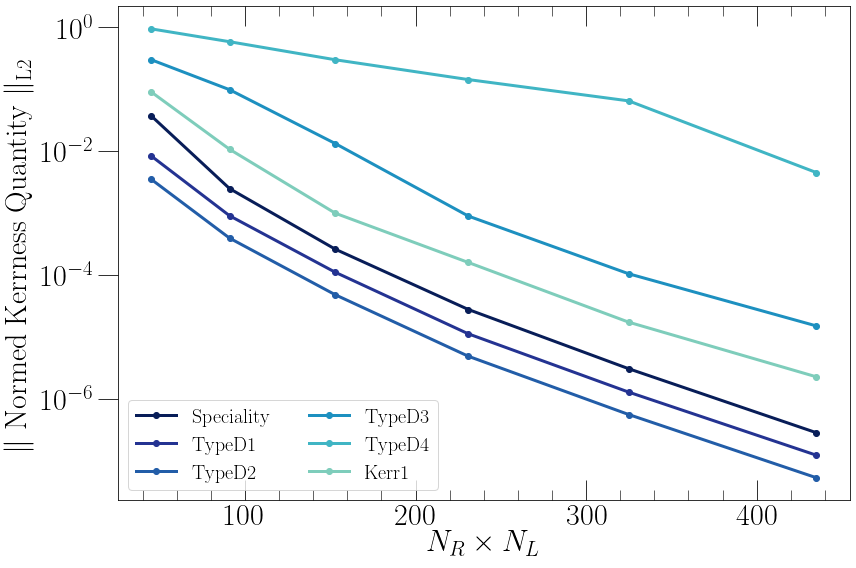

In [46]:
def PlotConvergence():
    
    # (spin 0.2, 0.3, 0.4)
    plt.figure(figsize=(12, 8))

    def ReadValue(col):
        p = "/Users/mokounkova/KerrnessBinaries/Data/SingleBH/"
        f = p + "QuantitiesNormed.dat"
        val = np.loadtxt(f, comments="#",usecols=([col]),unpack=True)
        return val
    
    def PlotValues():
        cmap = matplotlib.cm.get_cmap('YlGnBu')
        colors = [cmap((float(i) + 1)/8) for i in range(8)][::-1]
        labels = ['Speciality', 'TypeD1', 'TypeD2', 'TypeD3', 'TypeD4', 'Kerr1']
        cols = [1, 2, 3, 4, 5, 6]
        for col, c, lab in zip(cols, colors, labels):
            val = ReadValue(col)
            res = [(9 + 4*k)*(5 + 2*k) for k in range(len(val))]
            plt.plot(res, val,'-o', color = c, label = lab)

    
    PlotValues()
    
    plt.yscale('log')
    plt.legend(ncol = 2)
    plt.ylabel('$\|$ Normed Kerrness Quantity $\|_\mathrm{L2}$')
    plt.xlabel(r'$N_R \times N_L$')
    plt.tight_layout()
    plt.savefig('Convergence.pdf')
    plt.show()
    

PlotConvergence()

In [53]:
def GetPsi4ModeExtrapolated(p, mode=(2,2), order=2): 
    l = mode[0]
    m = mode[1]
    psi4_file = p + 'rMPsi4_Asymptotic_GeometricUnits.h5' 
    f = h5py.File(psi4_file, 'r')
    data = f['Extrapolated_N' + str(order) +'.dir']['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    time, re, im = data[:,0], data[:,1], data[:,2]
    Psi4 = re + 1j*im
    return time, Psi4

def GetStrainModeExtrapolated(p, mode=(2,2), order=2): 
    l = mode[0]
    m = mode[1]
    h_file = p + 'rhOverM_Asymptotic_GeometricUnits.h5' 
    f = h5py.File(h_file, 'r')
    data = f['Extrapolated_N'+str(order)+'.dir']['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    time, re, im = data[:,0], data[:,1], data[:,2]
    h = re + 1j*im
    return time, h

def CutTimes(time, data, TLow, TUp): 
    TLowIndex = np.where(time >= TLow)[0][0]
    TUpIndex = np.where(time <= TUp)[0][-1]
    time = time[TLowIndex:TUpIndex]
    data = data[TLowIndex:TUpIndex]
    return time, data

def GetPeakTimeMode(time, data): 
    ## Peak time being the peak of the magnitude of the data
    t_peak = time[np.argmax(np.absolute(data))]
    return t_peak

def SubtractPeakTimeMode(time, data): ###
    t_peak = GetPeakTimeMode(time, data)
    return time - t_peak

# Overtones fits

In [60]:
spin_final = 0.692
mfinal = 0.9525

def PerturbationTheoryResult(mode, spin):
    """ Returns analytical result for a given run with initial spins
        spin, for a given mode"""

    L = mode[0]
    M = mode[1]
    N = mode[2]
    mode_nums = [(-2, L, M, N)]
    modes = [ksc(*mode_num) for mode_num in mode_nums]
    chi_f = spin

    omega_times_M = [np.real(mode(chi_f)[0]) for mode in modes][0] # List of omegas
    tau_over_M = [-1./np.imag(mode(chi_f)[0]) for mode in modes][0] # List of taus
 
    # returns the true omega and the tau, without factors of m around  
    return omega_times_M / mfinal, tau_over_M * mfinal

PerturbationTheoryResult((2,2,0), spin_final)

(0.5554705786511481, 11.746211415019749)

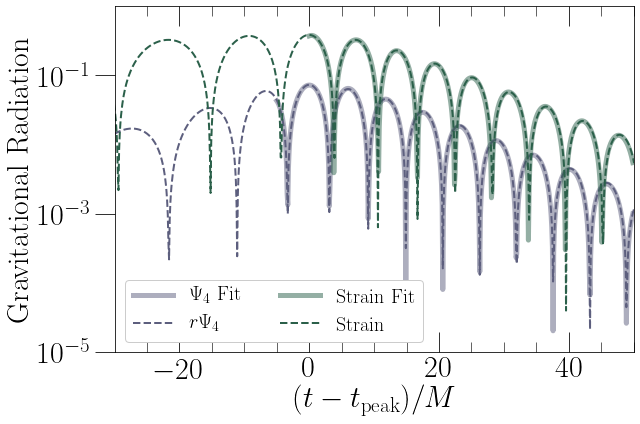

In [97]:
## QNM fits

def QNMFitOvertones(time, waveform, mode=(2,2)):
    """ Fits 3 GR overtones to a given mode of 
        a background gravitational waveform ringdown """
    
    L = mode[0]
    M = mode[1]
    
    def tone(t, A, delta, N):
        omega, tau = PerturbationTheoryResult((L,M,N-1), spin_final)
        ## Use the real part to get A and delta for each of the overtones
        P = A*np.exp(-t/tau)*np.cos(-t*omega + delta)
        return P

    def tone_func(t, A1, A2, A3, delta1, delta2, delta3):
        t = t - t[0]

        P1 = tone(t, A1, delta1, 1)
        P2 = tone(t, A2, delta2, 2)
        P3 = tone(t, A3, delta3, 3)
        
        return P1 + P2 + P3 
    
    popt, pcov = curve_fit(tone_func, time, waveform, maxfev = 40000)
    fit = tone_func(time, *popt)
    return time, fit, popt

def FitOvertones():     

    f, ax = plt.subplots(1, figsize=(9,6))
    
    def FitData(time, data, start, end):
        time, data = CutTimes(time, data, start, end)
        timefit, fit, popt = QNMFitOvertones(time, data)
        return timefit, fit 

    time, data = GetPsi4ModeExtrapolated("/Users/mokounkova/KerrnessBinaries/Data/Overtones_Prep/") 
    data = np.real(data) 
    time =  SubtractPeakTimeMode(time, data)
    timefit, fit = FitData(time, data, -5, 50)

    ax.plot(timefit, np.abs(fit), lw=5.0, color = '#5d5f7e', label=r'$\Psi_4$ Fit', alpha=0.5)
    ax.plot(time, np.abs(data), color = '#5d5f7e', ls='--', lw = 2.0, label=r'$r\Psi_4$')
    

    time, data = GetStrainModeExtrapolated("/Users/mokounkova/KerrnessBinaries/Data/Overtones_Prep/") 
    data = np.real(data) 
    time =  SubtractPeakTimeMode(time, data)
    timefit, fit = FitData(time, data, 0, 50)

    ax.plot(timefit, np.abs(fit), lw=5.0, color = '#2b604a', label=r'Strain Fit', alpha=0.5)
    ax.plot(time, np.abs(data), color = '#2b604a', ls='--', lw = 2.0, label=r'Strain')
    

    ax.set_yscale('log')
    ax.set_ylabel('Gravitational Radiation', fontsize=30)
    plt.xlim(-30, 50)
    plt.ylim(1e-5, 1)
    ax.legend(loc='lower left', framealpha=1.0, frameon=True, fontsize=20, ncol=2)
    ax.set_xlabel('$(t - t_\mathrm{peak})/M$') 
    plt.tight_layout()
    plt.savefig('Overones.pdf')
    plt.show()     


FitOvertones()